# TP SSM

_Mestre Yannis_

_Ravenel Pierre_

11/12/21

# Introduction

L'objectif de ce rapport est d'introduire la sécurité matérielle à travers des campagnes d'injections de fautes.
L'idée est d'introduire des fautes dans un système et de voir si les résultats produits sont cohérents. Une faute engendre une erreur si le système n'est pas robuste aux fautes.

Quatres éléments sont clées pour réaliser une campagne de test:
1. Un système de test
2. Un banc de test
3. Un modèle de faute
4. Une étape de collecte et de traitement des données

## Un système de test (Design Under Test: DUT)

Le système de test est un modèle RTL. Dans notre cas, c'est un multiplieur que nous caractériserons. Il s'agit de savoir si il produit toujours les bonnes valeurs. Si il produit une mauvaise valeur, on parlera d'erreur.

## Un banc de test

Il s'agit d'une autre composant RTL permettant de tester le premier (le DUT). Celui ci vérifie simplement que les résultats du premier sont bien ceux attendues. Les entrées et sorties attendue du multiplieurs sont fournies par le programmeur.

Théoriquement, nous devrions tester toutes les entrées et sorties, soit $2^{16} . {2^{16}}$ combinaison. Pour être exaustif, il faut réaliser beaucoup de simulations. Cela n'étant pas possible, nous testerons uniquement quelques cas, par exemple $13.11=143$. 

## Un modèle de faute

Quand nous parlons de fautes, nous les définissions commes des SEU (single event upset). C'est a dire que pour une simulation, à un unique instant t, un unique bit est mis à 1. Cette hypothèse est raisonable pour étudier théoriquement les circuits numériques. Nous pouvons la justfier théoriquement :

Une faute provient des rayons cosmiques. Nous modélisons leur apparitions par une loi de poisson de parametre lambda égale à une valeur MTBF (Mean  Time  Between  Fault) de 100us. Celle ci est admise empiriquement pour notre multiplieur. Sachant que nous réalisons une simulation de 9.2us, nous devrions observer 0.1 SEU par simulation en moyenne. Alors, on peut bien admettre que nous pouvons simuler tous les cas possible avec un unique bit flip par simulation. Notons que si nous avions fixé un MTBF de 5us, alors nous aurions du simuler tous les cas avec 2 fautes par simulations. Cela devient vite une explosion combinatoire.


## Une étape de collecte et de traitement des données

Il s'agit ici d'analyser les résultats des simulations. En effet, dans notre campagne d'injection de fautes, nous réalisons des SEU à tous les bits et a tout les instant du programmes. Ceux ci forme l'espace d'injection de fautes. Dans notre cas, l'espace est une grille de `71 bits de registres X 175 cycles d'horloge = 12425 simulations`.

Notre pipeline de travail est la suivante:

1. Définition de composant a tester (VHDL)
2. Définition de la campagne d'injection (espace d'injection)
3. Simulation (RTL / TCL / VSIM)
4. Analyse statistique (Python)



In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="ticks")
sns.set_style("ticks",{'axes.grid' : True})

In [2]:
# some funcs
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    figsize = plt.rcParams.get('figure.figsize')


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
    plt.tight_layout()
    
def plot_mat_time_bit_bin(mat, title):
    fig = plt.figure(figsize=(15,4))
    ax = sns.heatmap(mat, cmap=sns.color_palette("Set2", 2), square=True, linewidth=0.0, linecolor=(0.1,0.2,0.2))
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([0.25, 0.75])
    colorbar.set_ticklabels(['true', 'false'])
    plt.xlabel('time')
    plt.ylabel('bit')
    plt.title(title)

def plot_mat_time_bit_confusion(mat, title):
    fig = plt.figure(figsize=(15,4))
    ax = sns.heatmap(mat, cmap=sns.color_palette("Set2", 4), square=True, linewidth=0.0, linecolor=(0.1,0.2,0.2))
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([0, 1, 2, 3])
    colorbar.set_ticklabels(['true positive', 'false positive', 'false negative', 'true negative'])
    plt.xlabel('time')
    plt.ylabel('bit')
    plt.title(title)

In [3]:
# Load data

# Error matrix
df_err = pd.read_csv("full_space_error.csv")
df_err_mat = df_err.pivot('bit', 'time', 'err').values

# Detection matrix
df_det = pd.read_csv("double_space_detection_spatial.csv")
df_det_mat_double = df_det.pivot('bit', 'time', 'err').values
df_det = df_det.loc[df_det['bit'] <= 71]
df_det_mat = df_det.pivot('bit', 'time', 'err').values

# Detection matrix tempo
df_det_tempo = pd.read_csv("space_detect_tempo.csv")
df_det_tempo_mat = df_det_tempo.pivot('bit', 'time', 'err').values

# Correction matrix spatial
df_correction_spatial = pd.read_csv("space_correction_spatial.csv")
df_correction_spatial_mat = df_correction_spatial.pivot('bit', 'time', 'err').values

# Correction matrix tempo
df_correction_tempo = pd.read_csv("space_correction_tempo.csv")
df_correction_tempo_mat = df_correction_tempo.pivot('bit', 'time', 'err').values

# Simulation du modèle

On affiche ici l'espace d'injecion de fautes en précisant si oui ou non la faute produit une erreur.
On observe en abscisse le temps et en y les bits des registres dans lequel nous réalisons des bit set. Dans l'ordre, il y a les registres 
ACC sur 16 bits, B sur 16 bits, MQ sur 16 bits, CPTR sur 16, D sur 1 bit et les états de la FSM de la partie controle.

* Au centre, nous observons un point bleu si la faute sur le bit i a l'instant t provoque une erreur.
* Dans les marginales de notre graphique nous observons la somme des lignes et des colonnes. Ils permettent de savoir les instants critiques et les registres critiques.
* On analyse que tous les registres ne sont pas aussi sensibles aux fautes. Par exemple le registre de la FSM est très sensible car une faute implique dans quasiment tous les cas une erreur.
* Sur l'axe du temps, nous observons à intervalle régulier qu'une erreur ne provoque pas de fautes. Cela est normal car ce sont les temps de test entre deux multiplications.
* On observer aussi des motif en droite décroissantes dans l'espace d'inejctions. Cela sont du aux fait que certains bit des registres sont moins critique que d'autres.


<Figure size 1080x288 with 0 Axes>

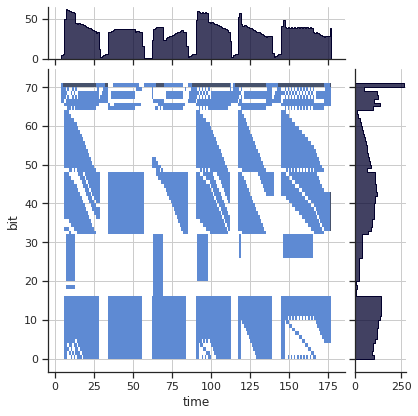

In [4]:
fig = plt.figure(figsize=(15,4))
g = sns.JointGrid(data=df_err.loc[df_err['err'] == 1], x="time", y="bit", marginal_ticks=True)
g.plot_joint(sns.histplot, binwidth=1)
g.plot_marginals(sns.histplot, binwidth=1, element="step", color="#03012d")

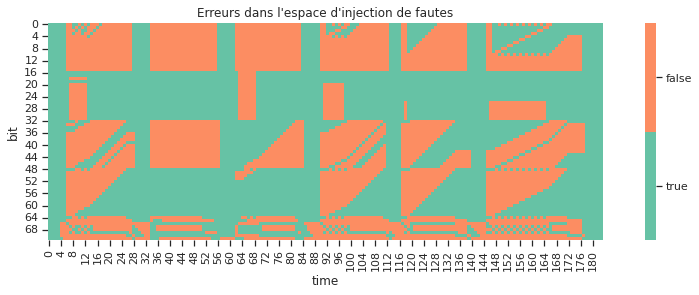

In [5]:
plot_mat_time_bit_bin(df_err_mat, 'Erreurs dans l\'espace d\'injection de fautes')

Par la suite, nous utiliserons cette représentation simplifiée de l'espace d'injection.

## Synthèse

# Détection de fautes avec un modèle redondé
 
_Nous savons à présent que notre modèle produit des erreures quand on lui injecte de fautes. Il s'agit alors de les detecter au niveau RTL. Cela permettra par la suite de les corriger._

Pour détecter les fautes, nous allons utiliser de la redondance de données. L'idée est de réaliser un calcul supplementaire permettant de prouver que le calcul initial est valide.

La redondance peut s'introduire à 3 niveau:
1. Au niveau spatial: on fait tourner deux modèles en parallèle et enfin comparons leurs résultats.
2. Au niveau temporel: on fait tourner successivement deux fois le même modèle avec les mêmes valeurs et et enfin comparons les résultats.
3. Au niveau des mots avec un codage detecteur d'erreur. On peut citer ici l'ajout d'un bit de parité. Ce bit est un indicateur de l'intégrité de la donnée.

Dans le cadre de SEU que nous avons définis, ces 3 modèles permettent une détection optimale. Nous testerons uniquement les points 1 et 2.

## Redondance spatiale

Dans la redondance spatiale, on fait tourner deux modèles en parallèle et enfin comparons leurs résultats. Si ils sont égaux, alors on peut dire suivant nos hypothèse initiales que le résultat est valide.

![Redondance S 2](./273554_1_En_4_Fig11_HTML.gif)


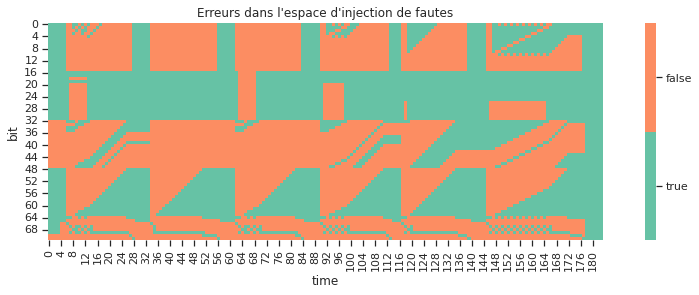

In [6]:
plot_mat_time_bit_bin(df_det_mat, 'Erreurs dans l\'espace d\'injection de fautes')

Ici nous observons la sortie du detecteur de fautes. L'état faux indique que le signal d'erreur passe à 1. Verifons si son comportement est bon en analysant les TP, FP, TN, FN.

nb_tp=6408 nb_fp=1153 0 nb_tn=5687


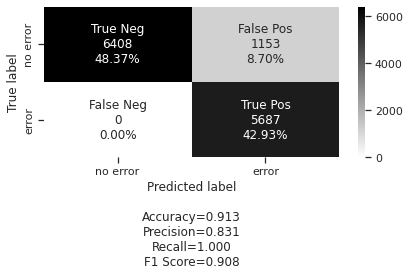

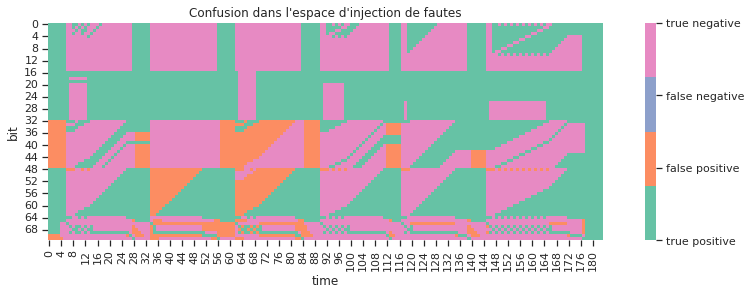

In [7]:
# Calcul de la matrice de confusion (TIME, BIT)
mat = df_err_mat * 2 + df_det_mat
nb_tp = np.sum(mat == 0)
nb_fp = np.sum(mat == 1)
nb_fn = np.sum(mat == 2)
nb_tn = np.sum(mat == 3)

print(f"{nb_tp=} {nb_fp=} {nb_fn} {nb_tn=}")

# Calcul de la matrice de confusion (ETAT)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['no error', 'error']
make_confusion_matrix(np.array([[nb_tp, nb_fp],[nb_fn, nb_tn]]), 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary',
                      figsize=(1,4))

plot_mat_time_bit_confusion(mat, 'Confusion dans l\'espace d\'injection de fautes')

* Positif ou négatif détaille si une erreur est detectée. Un comportement positif indique que le test détecte une erreur. Un comportement négatif implique que le test NE détecte PAS d'erreur.
* Vrai ou faux détaille si l'erreur déclenche une faute. Si vrai, la la faute déclenche bien l'erreur.

On cherche ici à avoir ici un système ne retournant que des vrais positifs (il y a vraiment une erreur, et elle est détectée) et des vrais négatifs (il n'y a pas d'erreur, et on ne détecte rien). Dans ce cas, toutes les erreurs sont bien detectées, et seulement les erreurs.

Mais en pratique, ce n'est pas ce que nous observons. En effet, il y a des faux positifs qui correspondent à des detections d'erreurs alors que la faute ne déclenche pas d'erreur. Ce cas n'est pas trop génant car il réduit simplement la précision de notre système. (0.83).

Le cas génant aurait été les faux négatifs. C'est a dire que nous ne détecterions pas d'erreurs quand elle seraient vraiment présentes. Bien heureusement, ce cas n'apparait pas dans notre système. Ainsi, nous avons la possibilité d'avoir un sur-système qui ne produit j'amais d'erreur. En effet, notre valeur de recall est de 1. C'est ce que nous allons chercher a faire par la suite en introduisant plus de redondance.

_Note: Le faux positif provient du fait que la sortie du composant est la sortie du premier sous composant. Ce cas se produit quand le deuxieme composant est en erreur alors que le premier est juste._


## Redondance temporelle

Dans le cadre de la redondance temporelle, on fait tourner successivement deux fois le même modèle avec les mêmes valeurs et et enfin comparons les résultats.

![Redondance T 2](./273554_1_En_6_Fig1_HTML.gif)

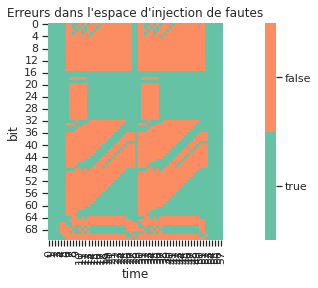

In [8]:
plot_mat_time_bit_bin(df_det_tempo_mat, 'Erreurs dans l\'espace d\'injection de fautes')

Ici nous observons la sortie du detecteur de fautes. L'état faux indique que le signal d'erreur passe à 1. Par simplicité, nous avons effectué le test sur une unique multiplication.

Plusieurs points sont intéressant à observer:

* Nous observons bien 2 fois le même motif qui correspond à une multiplication successive.
* Le comportement de faute à erreur est bien symétrique en fonction des deux mesures.
* Nous retrouvons exactement le même comportement que dans la redondance spatiale. En effet, d'après les hypothèses de SEU que nous avons fixées initialement, nous ne pouvons pas avoir plusieurs fautes.

Ainsi, nous pouvons supposer une détection égale à celle du système à redondance spatiale.


## Synthèse et comparaison

Nous avons implémenté en VHDL des nouveaux composants implémentant la détection spatiale et temporelle. Celle si permet de savoir si un SEU introduit une erreur dans le système. Dans les deux cas, nous avons obtenue exactement les mêmes performances en terme de détection. C'est à dire un système sans faux négatif. Cela est très intéressant car cela implique que a minima toutes les erreurs seront bien détectées bien que certaines non erreurs seront interprétées commes des erreurs (FN).

La redondance spatiale est la plus simple à mettre en place car elle n'implique aucun changement temporel du système. Toutefois, elle implique de doubler la surface. La détection temporelle prend peu de place, mais le système est deux fois plus lent. Aussi, il est intéressant de noter que la redondance temporelle implique d'autres composants (mémoire) ce qui rend plus sensible le système au SEU.

Notons que nous avons uniquement implémenté de la repondance spatiale et temporelle; mais celle ci peut aussi se faire niveau des mots avec un codage detecteur d'erreur. On peut citer ici l'ajout d'un bit de parité. Ce bit est un indicateur de l'intégrité de la donnée.

Maintenant que nous savons détecter des fautes, il est alors intéressant de les corriger.

# Correction de fautes avec un modèle redondé

Pour corriger les fautes, nous allons utiliser de la redondance de données. L'idée est de réaliser un calcul supplementaire permettant de proposer la valeur la plus probable.

La redondance peut s'introduire à 3 niveau:
1. Au niveau spatial: on fait tourner trois modèles en parallèle et enfin comparons leurs résultats.
2. Au niveau temporel: on fait tourner successivement trois fois le même modèle avec les mêmes valeurs et et enfin comparons les résultats.
3. Au niveau des mots avec un codage correcteur d'erreur. On peut citer ici le code de hamming.

Dans le cadre de SEU que nous avons définis, ces 3 modèles permettent une correction optimale. Nous testerons uniquement les point 1 et 2.

# Correction par redondance spatiale

L'idée ici est d'instancier 3 fois le même modèle. Le résultat produit est celui qui est majoritaire. Un système de vote permet cela.

![Redondance S 3](./273554_1_En_4_Fig3_HTML.gif)

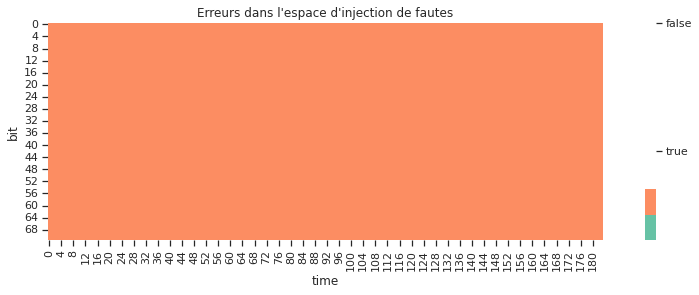

In [9]:
plot_mat_time_bit_bin(df_correction_spatial_mat, 'Erreurs dans l\'espace d\'injection de fautes')

On observe ici qu'aucune erreur apparait. Cela est très bien car aucune faute n'induit d'erreur. Notre correcteur spatial est performant. Il est inutile de calculer ici les TP FP TN FN car tout est bien en TP.

# Correction par redondance temporelle

L'idée ici tourner successivement trois fois le même modèle avec les mêmes valeurs et et enfin comparons les résultats. Le résultat produit est celui qui est majoritaire. Un système de vote permet cela.
![Redondance T 3](./273554_1_En_6_Fig2_HTML.gif)

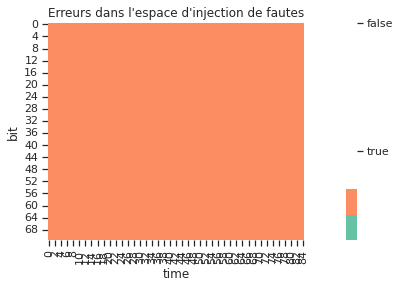

In [10]:
plot_mat_time_bit_bin(df_correction_tempo_mat, 'Erreurs dans l\'espace d\'injection de fautes')

Ici nous observons la sortie du detecteur de fautes. L'état faux indique que le signal d'erreur passe à 1. Par simplicité, nous avons effectué le test sur une unique multiplication. Le temps est alors de 3 période de multiplication plus le temps de vote.

On observe ici aucune erreur comme attendu. Le comportement est bien celui attendu. Cela comme pour le correcteur avec redondance spatiale.

# Synthèse de la correction

Nous avons implémenté en VHDL des nouveaux composants implémentant la correction spatiale et temporelle. Celle si permet de savoir si un SEU introduit une erreur dans le système. Dans les deux cas, nous avons obtenu exactement les mêmes performances en terme de correction. C'est à dire un système idéal. Cela se justifie bien théoriquement. En effet, suivant notre modèle de faute, il est impossible d'avoir deux erreures, dans un meme essai, alors avec une triple redondance, la sortie sera toujours juste.

La redondance spatiale est la plus simple à mettre en place car elle n'implique aucun changement temporelle du système. Toutefois, elle implique de tripler la surface. La détection temporelle prend peu de place, mais le système est trois fois plus lent. Aussi, il est intéressant de noter que la redondance temporelle implique d'autres composants (mémoire) ce qui rend plus sensible le système au SEU.

Notons que nous avons uniquement implémenté de la repondance spatiale et temporelle; mais celle ci peut aussi se faire niveau des mots avec un codage correcteur d'erreur. On peut citer ici le code Hamming. Il permet la détection et la correction automatique d'une erreur si elle ne porte que sur un bit du mot. 


# Conclusion

Dans ce tp, nous avons étudié la sécurité matérielle à travers des campagnes d'injections de fautes. L'idée fut d'intruiduire des fautes dans un système et de voir si les résultats produits sont cohérents. Un faute engendre une erreur si le système n'est pas robustes aux fautes.

Quatres étapes ont été clés pour réaliser une campagne de test:
1. Un système de test
2. Un banc de test
3. Un modèle de faute à définir
4. Une étape de collecte et de traitement des données

Ici nous avons implémenté des sursystèmes de detection et corrections pour un multiplieur 32bit dans le cadre de SEU.